In [488]:
# Cloning repository with the data for the experiment
# data -> thermalImagesClassificatoin/data/ ...

!git clone https://github.com/rgmantovani/thermalImagesClassification.git

fatal: destination path 'thermalImagesClassification' already exists and is not an empty directory.


In [489]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2 #opencv in pyhton
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [490]:
# For help: https://github.com/ribeiro-julio/crop-image-classification/blob/main/scripts/04_running_CNN.py

from tensorflow.keras import layers, models
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

from tensorflow.keras.applications import VGG19

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [491]:
# ----------------------------
# ----------------------------

# constant for experiment
num_classes = 2

TYPE_OF_IMAGE = "raw"
# TYPE_OF_IMAGE = "rgb"
# TYPE_OF_IMAGE = "gray"

# MODEL = "cnn"
# MODEL = "vgg19"
MODEL = "lwcnn"

# ----------------------------
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
# ----------------------------

SEEDS = [51, 171, 666, 404, 42]
current_seed = SEEDS[4]
print("Seed: ", current_seed)

keras.utils.set_random_seed(current_seed)

Seed:  42


In [492]:
# data directory
health_dir = "/content/thermalImagesClassification/data/saudaveis"
osteo_dir  = "/content/thermalImagesClassification/data/diagnosticos"

In [493]:
# loading filepaths
csv_files_health = glob.glob(os.path.join(health_dir, "**","*.csv"),recursive=True)
csv_files_osteo  = glob.glob(os.path.join(osteo_dir, "**", "*.csv"),recursive=True)

In [494]:
raw_file = csv_files_health[0]
print(raw_file)

/content/thermalImagesClassification/data/saudaveis/tibia_em_pe/Em_pe_118.csv


In [495]:
# ----------------------------------------------------------------------------
# Creating labels
# ----------------------------------------------------------------------------
Y_healthy = np.zeros(len(csv_files_health))
Y_osteo  = np.ones(len(csv_files_osteo))

# concatenating values
Y = np.concatenate((Y_healthy, Y_osteo))
# print(Y)

# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------

In [496]:
# --------------------------------------------------------------
# Splitting files into training and testing folds
# --------------------------------------------------------------
all_files = csv_files_health + csv_files_osteo

x_train_files, x_test_files, y_train, y_test = train_test_split(all_files,
    Y, test_size=0.3, random_state=42, stratify=Y)

In [497]:
print("Tamanho do X_train:", len(x_train_files))
print("Tamanho do X_test:", len(x_test_files))
print("Tamanho do y_train:", y_train.shape)
print("Tamanho do y_test:", y_test.shape)

Tamanho do X_train: 511
Tamanho do X_test: 220
Tamanho do y_train: (511,)
Tamanho do y_test: (220,)


In [498]:
# --------------------------------------------------------------
# function to plot thermal imagens from raw file
# --------------------------------------------------------------

def plot_csv_image(csv_file):
    data = pd.read_csv(csv_file, header=None)
    image_array = data.to_numpy()
    plt.imshow(image_array, cmap='inferno', interpolation='nearest')
    plt.colorbar()
    plt.show()

# --------------------------------------------------------------
# --------------------------------------------------------------

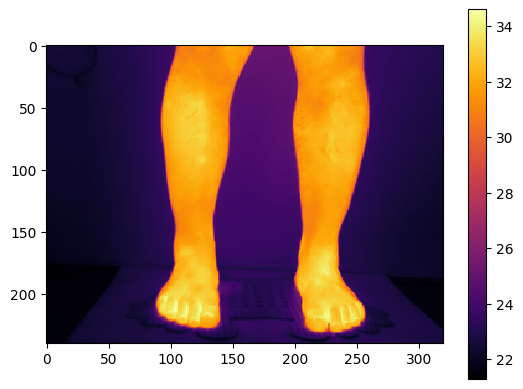

/content/thermalImagesClassification/data/saudaveis/tibia_em_pe/Em_pe_01.csv
0.0


In [499]:
plot_csv_image(csv_file=x_train_files[0])
# plot_csv_image(csv_file=x_test_files[0])
print(x_test_files[0])
print(y_test[0])

In [500]:
# --------------------------------------------------------------
# function to load thermal images from csv files
# --------------------------------------------------------------

def load_images_from_csv_files(csv_files):
  if not csv_files:
    raise Exception("No *.csv file was found.")

  raw_images = [pd.read_csv(file).to_numpy() for file in csv_files]
  return(raw_images)

# --------------------------------------------------------------
# --------------------------------------------------------------

In [501]:
# --------------------------------------------------------------
# reading images from files
# --------------------------------------------------------------

x_train_images = load_images_from_csv_files(csv_files=x_train_files)
print(x_train_images[0].shape)

x_test_images = load_images_from_csv_files(csv_files=x_test_files)
print(x_test_images[0].shape)


(239, 320)
(239, 320)


In [502]:
df = pd.DataFrame(x_train_images[0])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
0,22.52164,22.53780,22.54319,22.54858,22.54858,22.55396,22.55935,22.55935,22.55935,22.56474,...,23.10194,23.09658,23.09122,23.09122,23.09122,23.08051,23.07515,23.05907,23.04835,23.03226
1,22.52164,22.52703,22.53780,22.54319,22.54319,22.54858,22.54858,22.55396,22.55935,22.55935,...,23.10194,23.09122,23.09122,23.08587,23.08587,23.08051,23.06979,23.05907,23.04299,23.03226
2,22.51625,22.53242,22.53242,22.53242,22.53780,22.54319,22.54319,22.54858,22.54858,22.55396,...,23.09658,23.08587,23.08587,23.08051,23.08051,23.06979,23.06979,23.04835,23.03762,23.03226
3,22.51625,22.52703,22.53242,22.53780,22.53780,22.54319,22.54319,22.54858,22.54858,22.55396,...,23.09122,23.08051,23.08051,23.07515,23.06979,23.06443,23.04835,23.04299,23.03226,23.02690
4,22.52164,22.52703,22.53242,22.53780,22.53780,22.54319,22.54319,22.54319,22.54858,22.54319,...,23.08587,23.08051,23.06979,23.06443,23.06443,23.05907,23.04299,23.03762,23.02154,23.02154


In [503]:
# Min and Max temperature values in the raw image
selected_id = 50
print("Image: ", x_train_files[selected_id])
print("Min value: ", np.min(x_train_images[selected_id]))
print("Max value: ", np.max(x_train_images[selected_id]))
print("Mean: ", np.mean(x_train_images[selected_id]))

Image:  /content/thermalImagesClassification/data/diagnosticos/osteomielite_tibia/pessoa08/pessoa08_avaliacao01.csv
Min value:  21.39217
Max value:  33.4812
Mean:  26.335086919979084


In [504]:
# --------------------------------------------------------------
# normalize image withing [min, max] range
# --------------------------------------------------------------

def normalize(image):
    max = np.amax(image)
    min = np.amin(image)
    normalized_image = (image-min)/(max - min)
    return (normalized_image)

In [505]:
# -----------------------------------------------
# -----------------------------------------------

def thermal_to_rgb_image(image):
  norm_img = normalize(image = image)
  new_img  = np.round(norm_img * 255)
  u8 = new_img.astype(np.uint8)
  im_color = cv2.applyColorMap(u8, cv2.COLORMAP_JET)
  return(im_color)

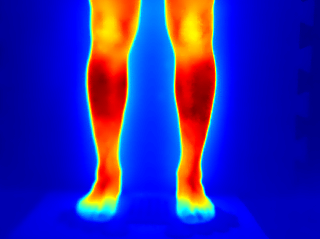

In [506]:
# example of RGB healthy image
imgc = thermal_to_rgb_image(image = x_train_images[2])
cv2_imshow(imgc)

In [507]:
imgc.shape

(239, 320, 3)

In [508]:
# converting all healthy thermal raw images to RGB

if(TYPE_OF_IMAGE == "rgb"):
  print("* Converting thermal images to RGB")
  new_x_train_images = [thermal_to_rgb_image(x) for x in x_train_images]
  new_x_test_images  = [thermal_to_rgb_image(x) for x in x_test_images]
  input_shape = (239, 320, 3)
else:
  print ("* Using raw images - normalized between [0, 1]")
  new_x_train_images = [normalize(x) for x in x_train_images]
  new_x_test_images  = [normalize(x) for x in x_test_images]
  input_shape = (239, 320, 1)
  print(new_x_train_images[0])

* Using raw images - normalized between [0, 1]
[[0.09241937 0.09363294 0.09403772 ... 0.13277896 0.13197392 0.1307656 ]
 [0.09241937 0.09282414 0.09363294 ... 0.13277896 0.1315714  0.1307656 ]
 [0.09201459 0.09322892 0.09322892 ... 0.13197392 0.13116813 0.1307656 ]
 ...
 [0.01759382 0.01800235 0.01759382 ... 0.10697324 0.10697324 0.10697324]
 [0.01759382 0.01759382 0.01759382 ... 0.1061652  0.10656922 0.10656922]
 [0.01718454 0.01718454 0.01759382 ... 0.10576117 0.10576117 0.1061652 ]]


In [509]:
# -------------------------------------------
# Creating Training Dataset
# -------------------------------------------
X_train = np.array(new_x_train_images)
X_test  = np.array(new_x_test_images)

In [510]:
# convert values to the inverval [0, 1]
if(TYPE_OF_IMAGE != "raw"):
  X_train = X_train.astype("float32") / 255
  X_test = X_test.astype("float32") / 255

In [511]:
# ------------------------------------------------------------
# ------------------------------------------------------------

# TODO: balanceamento no conjunto de treinamento
# Data augmentation da classe minoritaria (quais operacoes)
# usar data augmentation -> https://albumentations.ai/

# ------------------------------------------------------------
# ------------------------------------------------------------

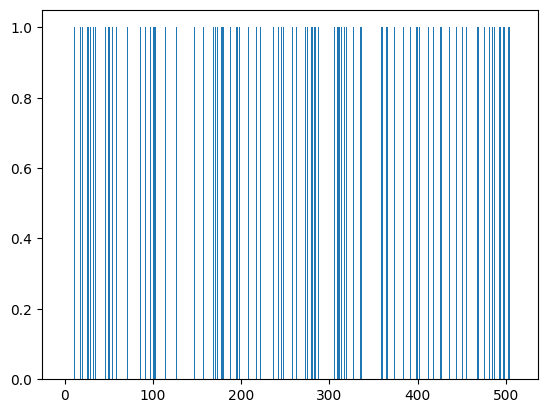

In [512]:
# print(y_test)
plt.bar(np.arange(len(y_train)),y_train)
plt.show()

In [513]:
# Classical CNN architecture
def get_CNN_model(input_shape):

	CNNmodel = models.Sequential()
	CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
	CNNmodel.add(layers.MaxPooling2D((2, 2)))
	CNNmodel.add(layers.Dropout(0.25))
	CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
	CNNmodel.add(layers.MaxPooling2D((2, 2)))
	CNNmodel.add(layers.Dropout(0.25))
	CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
	CNNmodel.add(layers.Flatten())
	CNNmodel.add(layers.Dense(64, activation='relu'))
	CNNmodel.add(layers.Dropout(0.5))
	CNNmodel.add(layers.Dense(1, activation="sigmoid"))

	return(CNNmodel)

In [514]:
def get_VGG19_model_Keras(input_shape) :

  VGGmodel = models.Sequential()
  baseModel = VGG19(input_shape=input_shape, weights='imagenet',include_top=False)
  baseModel.trainable = False
  VGGmodel.add(baseModel)
  VGGmodel.add(layers.Flatten())
  VGGmodel.add(layers.Dense(4096,activation = 'relu'))
  VGGmodel.add(layers.Dense(4096,activation = 'relu'))
  VGGmodel.add(layers.Dense(1,activation = 'sigmoid'))
  return(VGGmodel)

In [515]:
# TODO;
# ResNet50
# MobileNetV2

In [516]:
# Light weight convolutional neural network and low-dimensional images transformation approach for classification of thermal images
# https://www.sciencedirect.com/science/article/pii/S2214157X22009078

def get_LW_CNN_model_Taspinar(input_shape):

  LWCNN_model = models.Sequential()
  LWCNN_model.add(layers.Conv2D(6, (5, 5), input_shape=input_shape))
  LWCNN_model.add(layers.LeakyReLU(alpha=0.01))
  LWCNN_model.add(layers.MaxPooling2D((2, 2)))

  LWCNN_model.add(layers.Conv2D(16, (5, 5)))
  LWCNN_model.add(layers.LeakyReLU(alpha=0.01))
  LWCNN_model.add(layers.MaxPooling2D((2, 2)))

  LWCNN_model.add(layers.Conv2D(64, (3, 3)))
  LWCNN_model.add(layers.LeakyReLU(alpha=0.01))
  LWCNN_model.add(layers.MaxPooling2D((2, 2)))

  LWCNN_model.add(layers.Flatten())
  LWCNN_model.add(layers.Dense(128))
  LWCNN_model.add(layers.LeakyReLU(alpha=0.01))

  LWCNN_model.add(layers.Dropout(0.2))
  LWCNN_model.add(layers.Dense(1, activation="sigmoid"))

  return(LWCNN_model)

In [517]:
# Defining DL model
if(MODEL == "cnn"):
  model = get_CNN_model(input_shape=input_shape)
elif(MODEL == "vgg19"):
  model = get_VGG19_model_Keras(input_shape=input_shape)
else: # LWCNN
  model = get_LW_CNN_model_Taspinar(input_shape=input_shape)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 235, 316, 6)    │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_44 (LeakyReLU)      │ (None, 235, 316, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 117, 158, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 113, 154, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_45 (LeakyReLU)      │ (None, 113, 154, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 56, 77, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 54, 75, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_46 (LeakyReLU)      │ (None, 54, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 27, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 63936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │     8,183,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_47 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,195,917 (31.26 MB)

 Trainable params: 8,195,917 (31.26 MB)

 Non-trainable params: 0 (0.00 B)

In [518]:
model.compile(
    optimizer='adam',
    loss=BinaryCrossentropy(),
    metrics=['binary_accuracy', 'accuracy']
)

In [519]:
# import time

# class timecallback(tf.keras.callbacks.Callback):
#     def __init__(self):
#         self.times = []
#         # use this value as reference to calculate cumulative time taken
#         self.timetaken = time.process_time()
#     def on_epoch_end(self,epoch,logs = {}):
#         self.times.append((epoch, time.process_time() - self.timetaken))
#     def on_train_end(self,logs = {}):
#         plt.xlabel('Epoch')
#         plt.ylabel('Total time taken until an epoch in seconds')
#         plt.plot(*zip(*self.times))
#         plt.show()
#         from operator import itemgetter
#         previous_time = 0
#         for item in self.times:
#             print("Epoch ", item[0], " run time is: ", item[1]-previous_time)
#             previous_time = item[1]
#         print("Total trained time is: ", previous_time)

In [520]:
# ----------------------------
# Traninig the algorithm
# ----------------------------

# Callbacks
early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=10, verbose=1)
csv_logger    = CSVLogger(f"log_history_{MODEL}_{TYPE_OF_IMAGE}_seed_{current_seed}.csv", separator=",", append=False)
# timetaken     = timecallback()

print(f" - training {MODEL}")

history  = model.fit(X_train, y_train, epochs=100, validation_split=0.3, batch_size=16, callbacks=[early_stopper, csv_logger])

 - training lwcnn
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.5804 - binary_accuracy: 0.5804 - loss: 1.0878 - val_accuracy: 0.7792 - val_binary_accuracy: 0.7792 - val_loss: 0.3390
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8149 - binary_accuracy: 0.8149 - loss: 0.3307 - val_accuracy: 0.8377 - val_binary_accuracy: 0.8377 - val_loss: 0.3318
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8667 - binary_accuracy: 0.8667 - loss: 0.2897 - val_accuracy: 0.8961 - val_binary_accuracy: 0.8961 - val_loss: 0.2478
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9025 - binary_accuracy: 0.9025 - loss: 0.2129 - val_accuracy: 0.9026 - val_binary_accuracy: 0.9026 - val_loss: 0.2363
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9272 - binary_accuracy: 0.9272 - loss: 0.1760 - val_accuracy: 0.9026 - val_binary_accuracy: 0.9026 - val_loss: 0.2872
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accurac

In [521]:
# ----------------------------
# Evaluating predictions
# ----------------------------
print(" - Evaluating DL model")
predictions = model.predict(X_test)
rounded_predictions = np.round(predictions)
# print(rounded_predictions)

 - Evaluating DL model
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


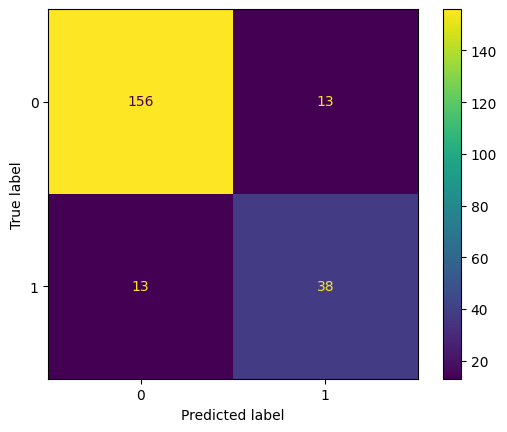

In [522]:
cm = confusion_matrix(y_test, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [523]:
# ----------------------------
# evaluating with scikit learn metrics
# ----------------------------
acc = accuracy_score(y_test, rounded_predictions)
bac = balanced_accuracy_score(y_test, rounded_predictions)
f1s = f1_score(y_test, rounded_predictions)
print("----------------------------")
print("acc = ", acc)
print("bac = ", bac)
print("f1c = ", f1s)
print("----------------------------")

performances = ([acc, bac, f1s, current_seed, TYPE_OF_IMAGE, MODEL])
print(performances)
df_performances = pd.DataFrame(performances).transpose()
df_performances.columns = ['accuracy', 'balanced_accuracy', 'fscore', 'seed', 'type_of_image', 'model']
df_performances.to_csv(f"performances_{MODEL}_{TYPE_OF_IMAGE}_seed_{current_seed}.csv", index = False)
df_performances.head()

----------------------------
acc =  0.8818181818181818
bac =  0.8340874811463047
f1c =  0.7450980392156863
----------------------------
[0.8818181818181818, np.float64(0.8340874811463047), 0.7450980392156863, 42, 'raw', 'lwcnn']


,accuracy,balanced_accuracy,fscore,seed,type_of_image,model
0,0.881818,0.834087,0.745098,42,raw,lwcnn


In [524]:
# -----------------------------------------------------------
# adding predictions to a data frame
# -----------------------------------------------------------

df_x_test_files = pd.DataFrame(x_test_files)
df_pred  = pd.DataFrame(rounded_predictions)
df_label = pd.DataFrame(y_test)
df_merged = pd.concat([df_x_test_files, df_pred, df_label], axis = 1)
df_merged.columns = ['filepath', 'predictions', 'labels']
df_merged.to_csv(f"predictions_{MODEL}_{TYPE_OF_IMAGE}_seed_{current_seed}.csv", index = False)
df_merged.head()

# -----------------------------------------------------------
# -----------------------------------------------------------

,filepath,predictions,labels
0,/content/thermalImagesClassification/data/saud...,0.0,0.0
1,/content/thermalImagesClassification/data/saud...,0.0,0.0
2,/content/thermalImagesClassification/data/saud...,0.0,0.0
3,/content/thermalImagesClassification/data/saud...,0.0,0.0
4,/content/thermalImagesClassification/data/diag...,1.0,1.0


In [525]:
print("Finished !!! :) ")

Finished !!! :) 
